In [1]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import torch
import copy
from sklearn.model_selection import KFold


from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

In [2]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)


In [3]:
from keras.optimizers import Adam

# Create the EEGNet model
model = EEGNet(nb_classes=4, Chans=22, Samples=176, dropoutRate=0.5, kernLength=22, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

# Compile the model
optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 176, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 22, 176, 8)        176       
                                                                 
 batch_normalization (Batch  (None, 22, 176, 8)        32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 176, 16)        352       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 176, 16)        64        
 chNormalization)                                                
                                                             

In [4]:
data_path = "D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf"

In [5]:
raw=mne.io.read_raw_gdf("D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01T.gdf", eog=['EOG-left', 'EOG-central', 'EOG-right'])

raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

Extracting EDF parameters from D:\Research Dr. Power\BCI_IV_2a\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


C:\ProgramData\Anaconda3\envs\BCI_2\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~26 kB, data not loaded>

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
if device == 'cuda':
    print("Running on cloud ...")
    print("Please make sure to modify how you read the data according to your need!\n\n")
    raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/Phase2/"
    data_epochs = []
    data_labels = []

    for participant_id in range(1, 10):
        participant = f"P{participant_id}"
        file_path = f"{raw_data_path}/{participant}.set"
        epochs = mne.io.read_epochs_eeglab(file_path)
        data_epochs.append(epochs.get_data())
        data_labels.append(epochs.events[:, -1])

elif device == 'cpu':
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:/Research Dr. Power/BCI_IV_2a/BCICIV_2a_gdf"
    train_data_epochs = []
    train_data_labels = []
    test_data_epochs = []
    test_data_labels = []
    for participant_id in range(1, 10):
        participant_E = f"A0{participant_id}E"
        participant_T = f"A0{participant_id}T"
        
        file_path_E = f"{raw_data_path}/{participant_E}.gdf"
        file_path_T = f"{raw_data_path}/{participant_T}.gdf"
        
        raw_train = mne.io.read_raw_gdf(file_path_T, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True).drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
        raw_test = mne.io.read_raw_gdf(file_path_E, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True).drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
        
        raw_train.set_eeg_reference()
        raw_test.set_eeg_reference()
        
        train_events = mne.events_from_annotations(raw_train)
        test_events = mne.events_from_annotations(raw_test)
        
        tmin = 0.504
        tmax = 2.5
        
        try:
            train_epochs = mne.Epochs(raw_train, train_events[0], event_id=[7,8,9,10], on_missing ='warn', tmin=tmin, tmax=tmax, baseline=None)
            test_epochs = mne.Epochs(raw_test, train_events[0], event_id=[7,8,9,10], on_missing ='warn', tmin=tmin, tmax=tmax, baseline=None)
        except ValueError:
            train_epochs = mne.Epochs(raw_train, train_events[0], event_id=[7,8,9,10], on_missing ='warn', tmin=tmin, tmax=tmax, baseline=(0, 0))
            test_epochs = mne.Epochs(raw_test, train_events[0], event_id=[7,8,9,10], on_missing ='warn', tmin=tmin, tmax=tmax, baseline=(0, 0))
        train_data_epochs.append(train_epochs.get_data())
        test_data_epochs.append(test_epochs.get_data())
        
        train_data_labels.append(train_epochs.events[:, -1])
        test_data_labels.append(test_epochs.events[:, -1])

In [8]:
train_events[0]

array([[     0,      0,      5],
       [     0,      0,      3],
       [ 30878,      0,      5],
       ...,
       [669791,      0,      8],
       [671350,      0,      6],
       [671850,      0,      9]])

In [9]:
train_events[1]

{'1023': 1,
 '1072': 2,
 '276': 3,
 '277': 4,
 '32766': 5,
 '768': 6,
 '769': 7,
 '770': 8,
 '771': 9,
 '772': 10}

In [10]:
raw_train[0][1].shape, raw_train[0][0].shape

((673328,), (1, 673328))

In [11]:
for i in range(9):
    
    train_data_epochs[i] = train_data_epochs[i][:, :, :, np.newaxis]
    test_data_epochs[i] = test_data_epochs[i][:, :, :, np.newaxis]

In [12]:
for i in range(9):
    print("Subject {} train epochs:    ".format(i+1), train_data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), train_data_labels[i].shape)
    print("Subject {} test epochs:     ".format(i+1), test_data_epochs[i].shape, "    Subject {} test labels:     ".format(i+1), test_data_labels[i].shape)

Subject 1 train epochs:     (288, 22, 1000, 1)     Subject 1 train labels:     (288,)
Subject 1 test epochs:      (288, 22, 1000, 1)     Subject 1 test labels:      (288,)
Subject 2 train epochs:     (288, 22, 1000, 1)     Subject 2 train labels:     (288,)
Subject 2 test epochs:      (280, 22, 1000, 1)     Subject 2 test labels:      (280,)
Subject 3 train epochs:     (288, 22, 1000, 1)     Subject 3 train labels:     (288,)
Subject 3 test epochs:      (282, 22, 1000, 1)     Subject 3 test labels:      (282,)
Subject 4 train epochs:     (144, 22, 1000, 1)     Subject 4 train labels:     (144,)
Subject 4 test epochs:      (144, 22, 1000, 1)     Subject 4 test labels:      (144,)
Subject 5 train epochs:     (288, 22, 1000, 1)     Subject 5 train labels:     (288,)
Subject 5 test epochs:      (285, 22, 1000, 1)     Subject 5 test labels:      (285,)
Subject 6 train epochs:     (288, 22, 1000, 1)     Subject 6 train labels:     (288,)
Subject 6 test epochs:      (281, 22, 1000, 1)     Sub

In [13]:
all_data_epochs = np.zeros(len(train_data_epochs)).tolist()
all_data_labels = np.zeros(len(train_data_epochs)).tolist()

for i in range(len(train_data_epochs)):
    all_data_epochs[i] = np.concatenate((train_data_epochs[i], test_data_epochs[i]), axis=0)
    all_data_labels[i] = np.concatenate((train_data_labels[i], test_data_labels[i]), axis=0)

In [14]:
# Checking if the concatenation does not have a problem!

print("Specific element in train and test sets:      ", train_data_epochs[i][10, 10, 10], test_data_epochs[i][100, 13, 14])
print("The same element in all data set combined:    ", all_data_epochs[i][10, 10, 10], all_data_epochs[i][388, 13, 14])
print("\n\n")
print("Checking the labels in train and test:        ", train_data_labels[i][10], test_data_labels[i][100])
print("The same element in all data set combined:    ", all_data_labels[i][10], all_data_labels[i][388])

Specific element in train and test sets:       [-1.54918324e-06] [6.61399148e-06]
The same element in all data set combined:     [-1.54918324e-06] [6.61399148e-06]



Checking the labels in train and test:         7 8
The same element in all data set combined:     7 8


In [15]:
for i in range(len(all_data_epochs)):
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)

All data epoch shape (sub 0):     (576, 22, 1000, 1)     All label shape (sub 0):      (576,)
All data epoch shape (sub 1):     (568, 22, 1000, 1)     All label shape (sub 1):      (568,)
All data epoch shape (sub 2):     (570, 22, 1000, 1)     All label shape (sub 2):      (570,)
All data epoch shape (sub 3):     (288, 22, 1000, 1)     All label shape (sub 3):      (288,)
All data epoch shape (sub 4):     (573, 22, 1000, 1)     All label shape (sub 4):      (573,)
All data epoch shape (sub 5):     (569, 22, 1000, 1)     All label shape (sub 5):      (569,)
All data epoch shape (sub 6):     (572, 22, 1000, 1)     All label shape (sub 6):      (572,)
All data epoch shape (sub 7):     (576, 22, 1000, 1)     All label shape (sub 7):      (576,)
All data epoch shape (sub 8):     (576, 22, 1000, 1)     All label shape (sub 8):      (576,)


In [16]:
all_data_epochs[0].shape

(576, 22, 1000, 1)

In [17]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [18]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [19]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[0].shape)
print("Participant 16 - labels[0] shape:", encoded[0].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[0])

Epochs Length: 9
labels Length: 9



Participant 16 - Epochs[0] shape: (576,)
Participant 16 - labels[0] shape: (576, 4)



Participant 16 - labels[0]:
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [20]:
a = []
b = [7, 8, 0.9899, 97, 34]

a.extend(b)

In [21]:
a

[7, 8, 0.9899, 97, 34]

# Cross-subject

Outer Loop 1 

      Train epochs' shape:                                (4295, 22, 1000, 1)
      Test epochs' shape:                                 (573, 22, 1000, 1)
      Test labels' shape:                                 (573, 4)
      Train labels' shape (without encoding):             (4295,)
      Test labels' shape (without encoding):              (573,)
      Train index:                                        [1, 2, 3, 4, 6, 7, 8, 9]
      Test index:                                         [5]



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
135/135 [==============================] - 23s 161ms/step - loss: 1.3786 - accuracy: 0.2976 - val_loss: 1.3866 - val_accuracy: 0.2443
Epoch 2/500
135/135 [==============================] - 27s 199ms/step - loss: 1.3496 - accuracy: 0.3388 - val_loss: 1.3822 - val_accuracy: 0.2880
Epoch 3/500
135/135 [==============================] - 35s 260ms/step - loss: 1.3334 - accuracy: 0.3509 - val_loss: 1.4003 - val_accuracy: 0.2932
Epoch 4/500
135/13

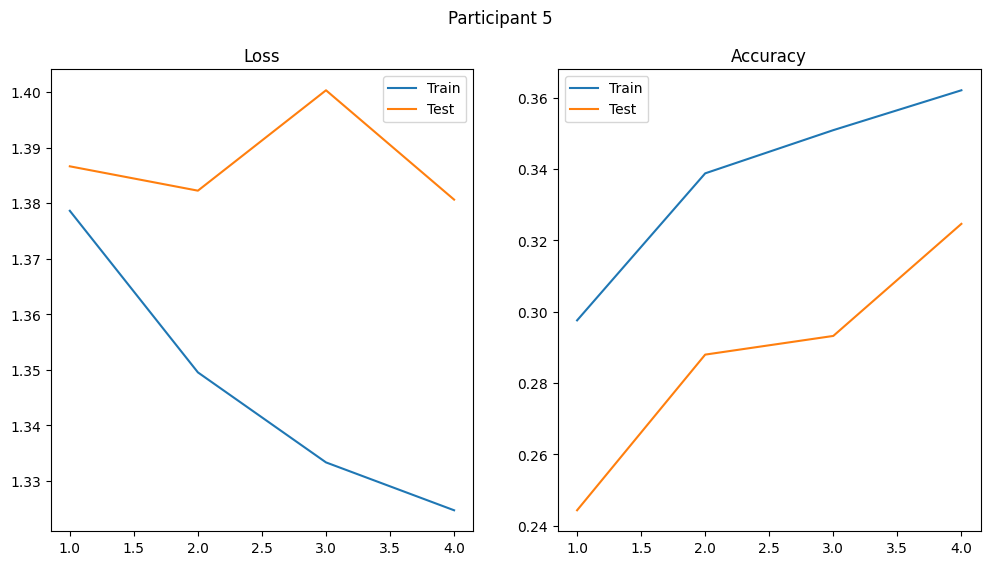

Outer Loop 2 

      Train epochs' shape:                                (4300, 22, 1000, 1)
      Test epochs' shape:                                 (568, 22, 1000, 1)
      Test labels' shape:                                 (568, 4)
      Train labels' shape (without encoding):             (4300,)
      Test labels' shape (without encoding):              (568,)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 9]
      Test index:                                         [2]



(1, 22, 1, 1)
(1, 22, 1, 1)
Epoch 1/500
135/135 [==============================] - 31s 215ms/step - loss: 1.3854 - accuracy: 0.2709 - val_loss: 1.3876 - val_accuracy: 0.2465
Epoch 2/500
135/135 [==============================] - 29s 215ms/step - loss: 1.3528 - accuracy: 0.3312 - val_loss: 1.3754 - val_accuracy: 0.3257
Epoch 3/500
 70/135 [==============>...............] - ETA: 12s - loss: 1.3346 - accuracy: 0.3589

In [ ]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9]
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0009



kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print('\n\n')
    
    
    # Create the EEGNet model
    model = EEGNet(nb_classes=4, Chans=22, Samples=500, dropoutRate=0.5, kernLength=22, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout')

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    patience = 60
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    
    # Normalizing the features
    mean = train_epochs.mean(axis=(0, 2, 3), keepdims=True)
    std = train_epochs.std(axis=(0, 2, 3), keepdims=True)
    
    print(mean.shape)
    print(std.shape)
    
    norm_train_epochs = (train_epochs - mean) / std
    norm_test_epochs = (test_epochs - mean) / std
    
    
    
    
    # Train the model
    history = model.fit(
        norm_train_epochs, train_labels,
        validation_data=(norm_test_epochs, test_labels),
        epochs=max_epochs,
        batch_size=32,  # Adjust as needed
        callbacks=[early_stopping]
    )

    # Collect training metrics
    train_loss_epochs.extend(history.history['loss'])
    train_acc_epochs.extend(history.history['accuracy'])

    # Collect testing metrics
    test_loss_epochs.extend(history.history['val_loss'])
    test_acc_epochs.extend(history.history['val_accuracy'])
    
    epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:-1*patience])
    plt.plot(epochs_range, test_loss_epochs[:-1*patience])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:-1*patience])
    plt.plot(epochs_range, test_acc_epochs[:-1*patience])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()